# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.optim as optim
from deep_rl import *
from MADDPG import *

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


When finished, you can close the environment.

In [30]:
env.close()

### 4. Training the Agent

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
config = Config()
config.seed = 42
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.action_size = brain.vector_action_space_size
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)

config.actor_hidden_units = (256,128)
config.actor_learning_rate = 3e-4
config.actor_network_fn = lambda: Actor(config.action_size, config.state_size, config.actor_hidden_units, config.seed).to(config.device)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_hidden_units = (1024,512)
config.critic_learning_rate = 3e-4
config.weight_decay = 0
config.critic_network_fn = lambda: Critic(config.action_size, config.state_size, config.critic_hidden_units, config.seed).to(config.device)
config.critic_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)

config.shared_replay_buffer = True
config.batch_size = 128
config.buffer_size = int(1e6)
config.discount = 0.99
config.update_every = 4
config.memory_fn = lambda: ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.seed, config.device)
config.tau = 6e-2
config.noise_fn = lambda: OUNoise(config.action_size, config.seed)


In [6]:
# maddpg = MADDPG(state_size, action_size, num_agents, 42)
maddpg = MADDPG(config)

In [7]:
def train(n_episodes = 2000):
    all_scores = []
    scores_window = deque(maxlen=100)
    time_step = 0

    for i_episode in range(1, n_episodes+1):
        maddpg.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations 
        scores = np.zeros(num_agents)
        while True:
            actions = maddpg.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            maddpg.step(states, actions, rewards, next_states, dones)
            time_step += 1
            scores += rewards
            states = next_states

            if np.any(dones):                                  # exit loop if episode finished
                break
                
        max_score = np.max(scores)
        scores_window.append(max_score)
        all_scores.append(max_score)
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(maddpg.ddpg_agents[0].actor_local.state_dict(), 'actor.pth')
            torch.save(maddpg.ddpg_agents[0].critic_local.state_dict(), 'critic.pth')

            break 
            
    return all_scores

In [8]:
scores = train()

Episode 100	Average Score: 0.0019
Episode 200	Average Score: 0.0100
Episode 300	Average Score: 0.0137
Episode 400	Average Score: 0.0461
Episode 500	Average Score: 0.1271
Episode 600	Average Score: 0.1701
Episode 700	Average Score: 0.3451
Episode 757	Average Score: 0.5018
Environment solved in 757 episodes!	Average Score: 0.5018


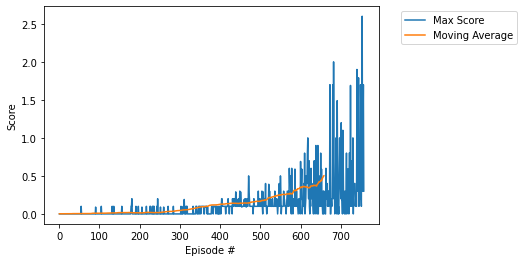

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
scores_moving_avg = moving_average(scores,100)
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(1, len(scores) + 1), scores, label="Max Score")
plt.plot(np.arange(1, len(scores_moving_avg) + 1), scores_moving_avg, label="Moving Average")

plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel("Score")
plt.xlabel("Episode # ")
plt.show()

